Collection done.


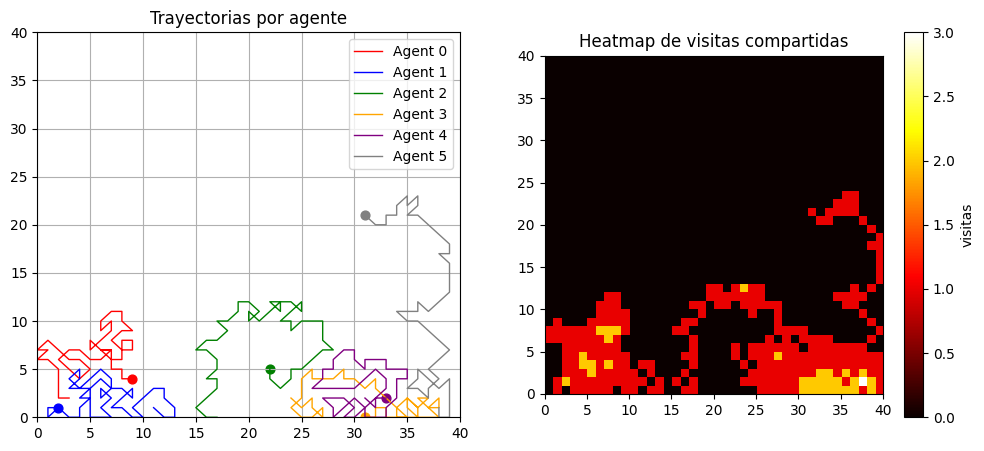

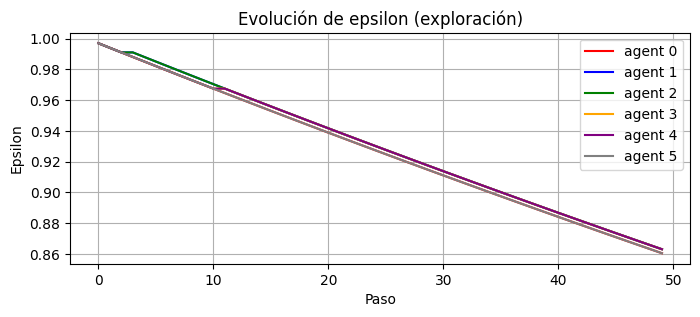

In [1]:
# notebook_plot_qcomm.py  (celda en Jupyter)
import requests
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation

#BASE = "https://api-john-deer.onrender.com" # p http://localhost:5000/ si lo corren local
BASE = "http://localhost:5000"
def get_state():
    r = requests.get(f"{BASE}/state")
    r.raise_for_status()
    return r.json()

def step():
    r = requests.post(f"{BASE}/step")
    r.raise_for_status()
    return r.json()

def reset():
    r = requests.post(f"{BASE}/reset")
    r.raise_for_status()
    return r.json()

# Collect data by running multiple steps
def run_collect(steps=200): #, delay=0.02):
    reset()
    traces = {i: [] for i in range(6)}  # positions per agent
    eps_history = {i: [] for i in range(6)}
    shared_visits = {}
    for t in range(steps):
        step()
        st = get_state()
        for a in st['agents']:
            aid = a['id']
            traces[aid].append((a['x'], a['y']))
            eps_history[aid].append(a['epsilon'])
        # update shared visits (overwrite)
        shared_visits = {tuple(v['cell']): v['count'] for v in st['shared_visited']}
        #time.sleep(delay)
    return traces, eps_history, shared_visits

# Run collection (adjust steps as you like)
steps = 50
traces, eps_hist, shared_visits = run_collect(steps=steps)#, delay=0.01)
print("Collection done.")

# Prepare heatmap of shared visits
map_size = get_state()['map_size']
heat = np.zeros((map_size, map_size))
for (cx, cy), c in shared_visits.items():
    if 0 <= cx < map_size and 0 <= cy < map_size:
        heat[int(cy), int(cx)] = c

# Plot trajectories and heatmap
colors = ['red','blue','green','orange','purple','gray']

fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot2grid((1,2),(0,0), colspan=1)
ax2 = plt.subplot2grid((1,2),(0,1), colspan=1)

# Trajectories
ax1.set_title("Trayectorias por agente")
ax1.set_xlim(0, map_size)
ax1.set_ylim(0, map_size)
for aid, pts in traces.items():
    arr = np.array(pts)
    if arr.size == 0: continue
    ax1.plot(arr[:,0], arr[:,1], '-', color=colors[aid], label=f'Agent {aid}', linewidth=1)
    ax1.scatter([arr[-1,0]],[arr[-1,1]], color=colors[aid], s=40)
ax1.legend()
ax1.grid(True)

# Heatmap
ax2.set_title("Heatmap de visitas compartidas")
im = ax2.imshow(heat, origin='lower', cmap='hot', extent=[0,map_size,0,map_size])
fig.colorbar(im, ax=ax2, label='visitas')
plt.show()

# Plot epsilon evolution
plt.figure(figsize=(8,3))
for aid, eps in eps_hist.items():
    plt.plot(eps, label=f'agent {aid}', color=colors[aid])
plt.xlabel('Paso')
plt.ylabel('Epsilon')
plt.title('Evolución de epsilon (exploración)')
plt.legend()
plt.grid(True)
plt.show()

Simulación completada.

==== MÉTRICAS DE SIMULACIÓN ====
Coverage: 58.94%
Celdas visitadas >=1 vez: 943
Overlap count (visitadas >1): 558
Collision attempts: 0

Distancia recorrida por agente:
 Agente 0: 476.29 unidades
 Agente 1: 474.26 unidades
 Agente 2: 478.28 unidades
 Agente 3: 478.94 unidades
 Agente 4: 484.74 unidades
 Agente 5: 0.00 unidades

No alcanzó cobertura total en los pasos dados.


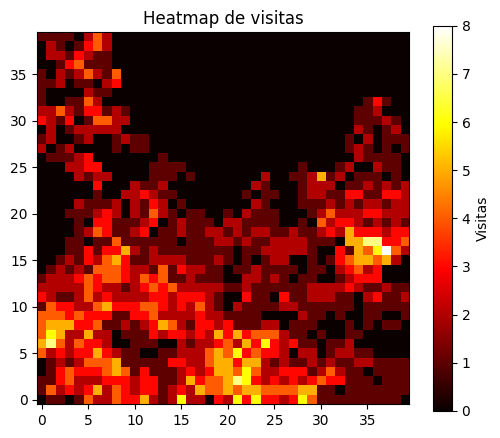

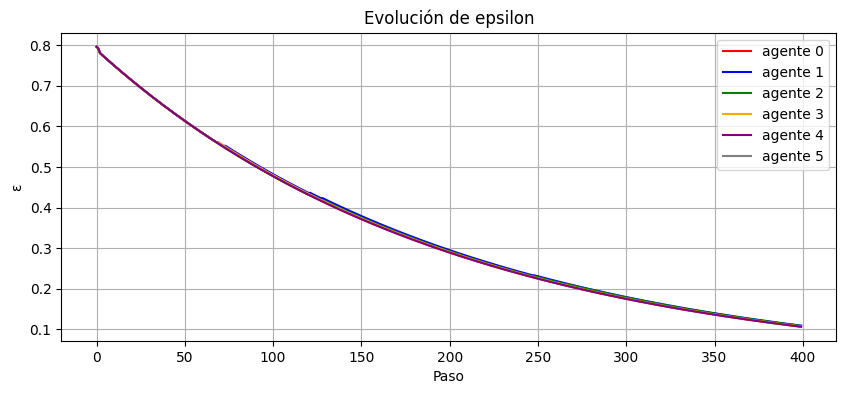

In [1]:
# notebook_plot_qcomm_metrics.py
import requests
import time
import numpy as np
import matplotlib.pyplot as plt

BASE = "https://api-john-deer.onrender.com"

def get_state():
    r = requests.get(f"{BASE}/state")
    r.raise_for_status()
    return r.json()

def step():
    r = requests.post(f"{BASE}/step")
    r.raise_for_status()
    return r.json()

def reset():
    r = requests.post(f"{BASE}/reset")
    r.raise_for_status()
    return r.json()


# -----------------------------
# MÉTRICAS
# -----------------------------
def compute_distance_traveled(trace):
    d = 0
    for i in range(1, len(trace)):
        x1, y1 = trace[i-1]
        x2, y2 = trace[i]
        d += np.sqrt((x2-x1)**2 + (y2-y1)**2)
    return d


def run_collect(steps=400, delay=0.01):
    reset()

    traces = {i: [] for i in range(6)}
    eps_history = {i: [] for i in range(6)}
    
    shared_visits = {}
    collision_attempts = 0

    for t in range(steps):
        step()
        st = get_state()

        # Save trajectories + epsilon
        positions = []
        for a in st["agents"]:
            aid = a["id"]
            traces[aid].append((a["x"], a["y"]))
            eps_history[aid].append(a["epsilon"])
            positions.append((a["x"], a["y"]))

        # Update shared visits
        shared_visits = {tuple(v["cell"]): v["count"] for v in st["shared_visited"]}

        # Count collision attempts (si dos agentes quedan a distancia < 1.0)
        for i in range(len(positions)):
            for j in range(i+1, len(positions)):
                dist = np.linalg.norm(np.array(positions[i]) - np.array(positions[j]))
                if dist < 1.0:
                    collision_attempts += 1

        time.sleep(delay)

    return traces, eps_history, shared_visits, collision_attempts


# -----------------------------
# EJECUTAR
# -----------------------------
steps = 400
traces, eps_hist, shared_visits, collision_attempts = run_collect(steps)

print("Simulación completada.\n")


# -----------------------------
# MÉTRICAS
# -----------------------------
map_size = get_state()["map_size"]
total_cells = map_size * map_size

visited_once = sum(1 for c in shared_visits.values() if c >= 1)
visited_multiple = sum(1 for c in shared_visits.values() if c > 1)

coverage = visited_once / total_cells * 100

# distance traveled per agent
distances = {aid: compute_distance_traveled(tr) for aid, tr in traces.items()}

# -----------------------------
# MOSTRAR MÉTRICAS
# -----------------------------
print("==== MÉTRICAS DE SIMULACIÓN ====")
print(f"Coverage: {coverage:.2f}%")
print(f"Celdas visitadas >=1 vez: {visited_once}")
print(f"Overlap count (visitadas >1): {visited_multiple}")
print(f"Collision attempts: {collision_attempts}")
print(f"\nDistancia recorrida por agente:")
for aid, d in distances.items():
    print(f" Agente {aid}: {d:.2f} unidades")

# PASOS HASTA COBERTURA
first_full = None
visited_progress = []

for t in range(steps):
    # count unique visited celdas at time t
    v = len(set(pos for aid in traces for pos in traces[aid][:t]))
    visited_progress.append(v)
    if v == total_cells and first_full is None:
        first_full = t

if first_full:
    print(f"\nPasos hasta cobertura total: {first_full}")
else:
    print("\nNo alcanzó cobertura total en los pasos dados.")


# -----------------------------
# HEATMAP
# -----------------------------
heat = np.zeros((map_size, map_size))
for (cx, cy), c in shared_visits.items():
    heat[int(cy), int(cx)] = c

plt.figure(figsize=(6,5))
plt.title("Heatmap de visitas")
plt.imshow(heat, origin='lower', cmap='hot')
plt.colorbar(label='Visitas')
plt.show()


# -----------------------------
# EVOLUCIÓN DE EPSILON
# -----------------------------
colors = ['red','blue','green','orange','purple','gray']

plt.figure(figsize=(10,4))
for aid, eps in eps_hist.items():
    plt.plot(eps, label=f"agente {aid}", color=colors[aid])
plt.title("Evolución de epsilon")
plt.xlabel("Paso")
plt.ylabel("ε")
plt.grid(True)
plt.legend()
plt.show()
